In [13]:
import numpy as np
import cv2
import mat73
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.widgets import RectangleSelector
from sklearn.decomposition import PCA
import torch.nn.functional as F

In [14]:
dataset_dir = 'data/'
mat_files = sorted([file for file in os.listdir(dataset_dir) if file.endswith('.mat')])
mat_files

# Specify inspection sequence
idx = 4
mat_data = scipy.io.loadmat(os.path.join(dataset_dir, mat_files[idx]))
image_sequence = np.float32(mat_data["imageArray"])
h, w, sequence_size = image_sequence.shape[0], image_sequence.shape[1], image_sequence.shape[2]

In [15]:
from scipy.signal import medfilt

def apply_median(pixel_signal):
    return medfilt(pixel_signal, kernel_size=3)

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, 12:1612]

imageMatrix = np.apply_along_axis(apply_median, axis=1, arr=imageMatrix)

imageMatrix = imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True)

n_components = 64
latent_dim = n_components

In [16]:
def kd_cosine_loss(z_student, z_teacher):
    z_student = F.normalize(z_student, dim=1)
    z_teacher = F.normalize(z_teacher, dim=1)
    loss = 1 - F.cosine_similarity(z_student, z_teacher, dim=1).mean()
    return loss

In [17]:
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(imageMatrix)

In [18]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)  
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)  
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
train_data = torch.tensor(imageMatrix, dtype=torch.float32, device=device)
z_pca_all = torch.tensor(pca_result, dtype=torch.float32, device=device)
dataset = TensorDataset(train_data, z_pca_all)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

model = Autoencoder(input_dim=train_data.shape[1], latent_dim=latent_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [20]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for x, z_pca in dataloader:
        x = x.to(device)
        z_pca = z_pca.to(device)

        optimizer.zero_grad()
        x_recon, z_ae = model(x)

        loss_recon = F.mse_loss(x_recon, x)
        loss_kd = kd_cosine_loss(z_ae, z_pca)

        loss = loss_recon + 10.0 * loss_kd

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f}, KD = {loss_kd.item():.4f}")

print(f"Epoch {epoch+1}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f}, KD = {loss_kd.item():.4f}")

Epoch 0: Total Loss = 25.7221 | Recon = 17.1402, KD = 0.8582
Epoch 10: Total Loss = 12.0128 | Recon = 10.2985, KD = 0.1714
Epoch 20: Total Loss = 10.0783 | Recon = 9.2564, KD = 0.0822
Epoch 30: Total Loss = 10.1557 | Recon = 9.8268, KD = 0.0329
Epoch 40: Total Loss = 10.8299 | Recon = 10.5143, KD = 0.0316
Epoch 50: Total Loss = 9.3048 | Recon = 9.0519, KD = 0.0253
Epoch 60: Total Loss = 9.1247 | Recon = 8.9895, KD = 0.0135
Epoch 70: Total Loss = 9.3170 | Recon = 9.0079, KD = 0.0309
Epoch 80: Total Loss = 10.1170 | Recon = 9.9456, KD = 0.0171
Epoch 90: Total Loss = 9.1790 | Recon = 9.0475, KD = 0.0132
Epoch 100: Total Loss = 8.9585 | Recon = 8.8493, KD = 0.0109


In [21]:
model.eval()
with torch.no_grad():
    _, principal_comp = model(train_data)

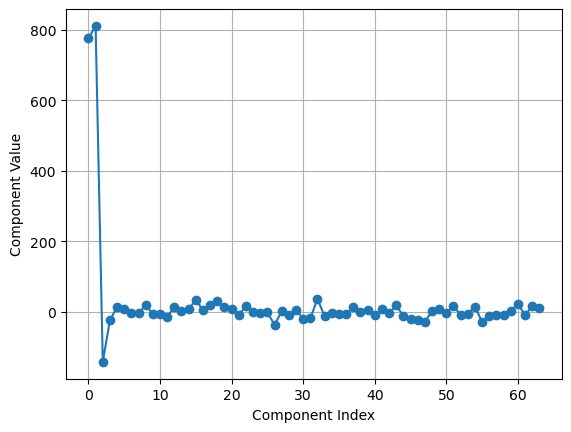

In [22]:
plt.plot(principal_comp[70000, :].cpu().numpy(), marker='o')
plt.xlabel("Component Index")
plt.ylabel("Component Value")
plt.grid(True)
plt.show()

In [23]:
pca_array = principal_comp.cpu().numpy().reshape(h, w, n_components)

pca_images = np.array([((pca_array[:, :, i] - np.min(pca_array[:, :, i])) /
                        (np.max(pca_array[:, :, i]) - np.min(pca_array[:, :, i]) + 1e-8))
                        for i in range(n_components)])

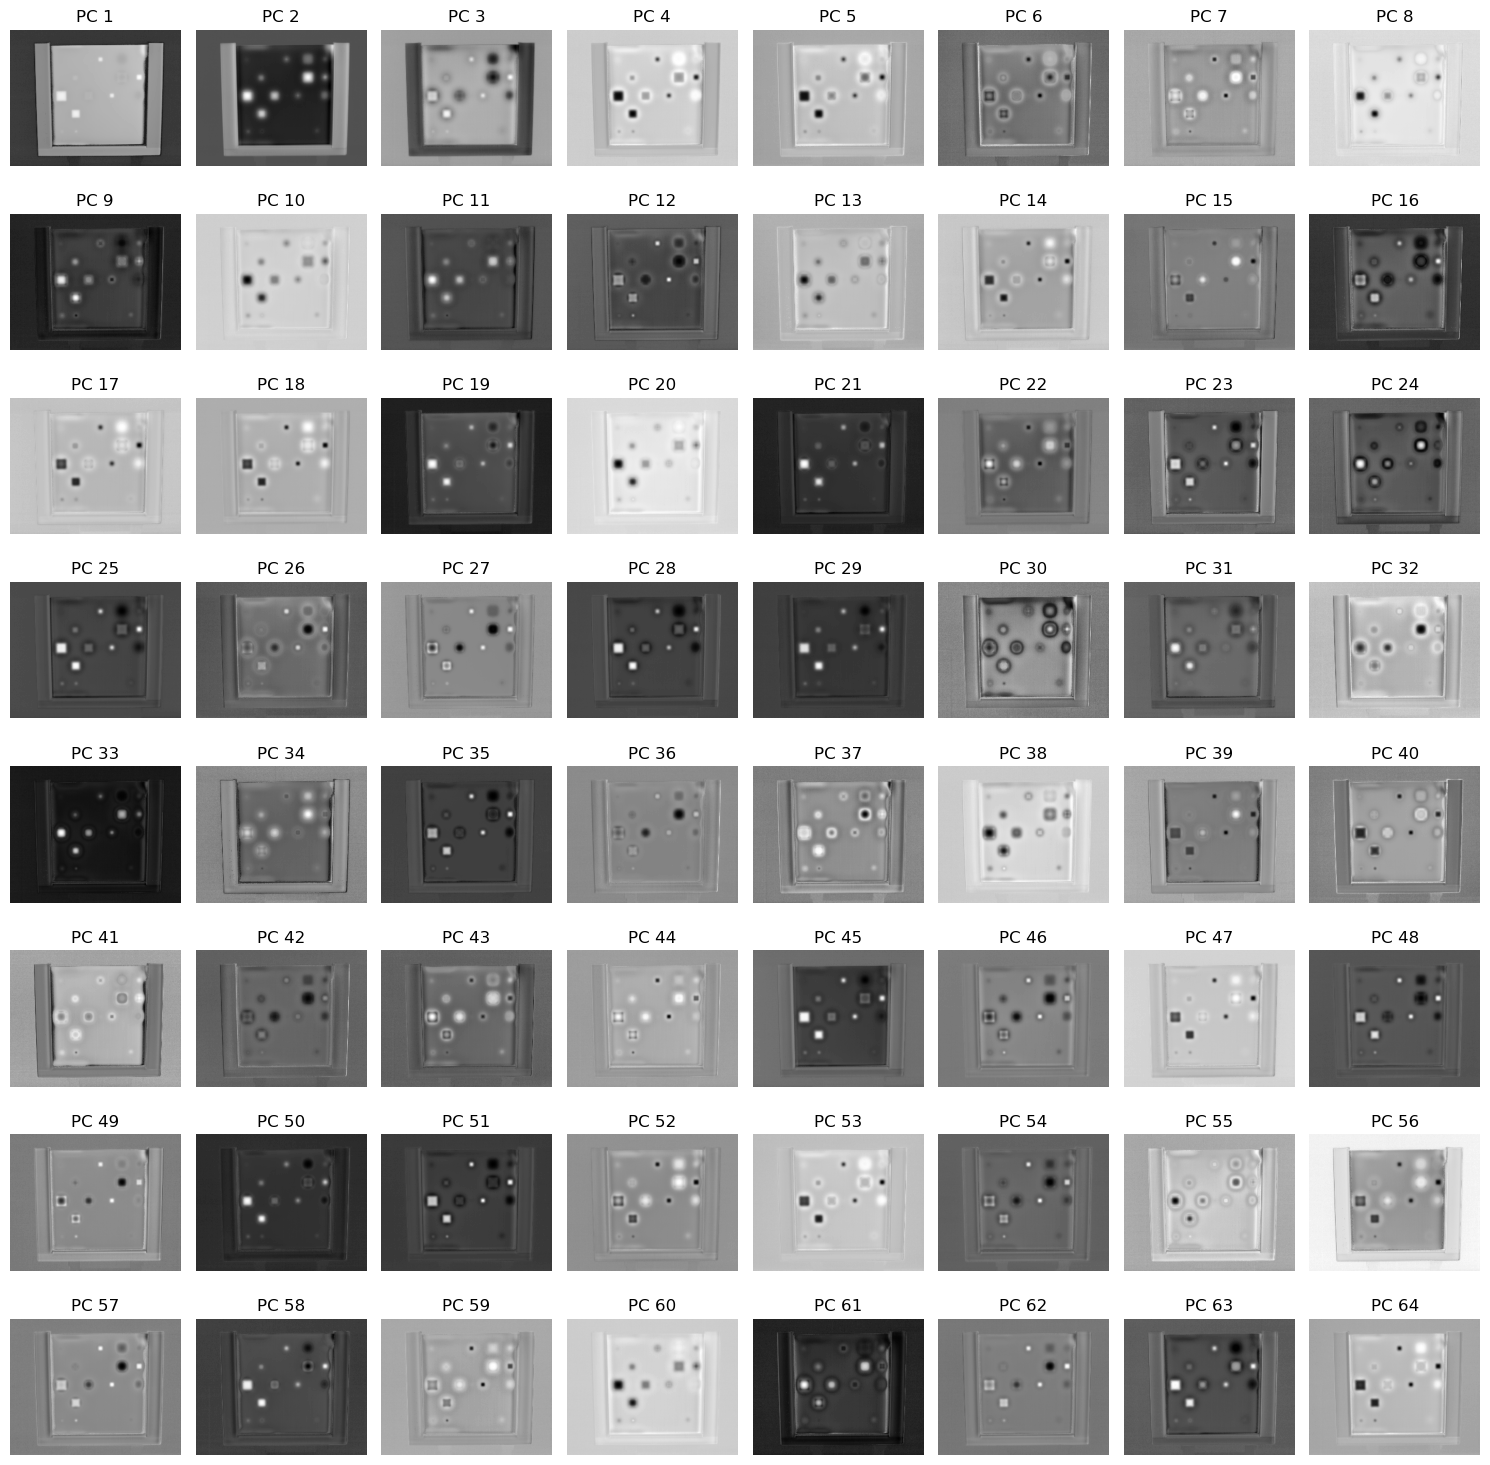

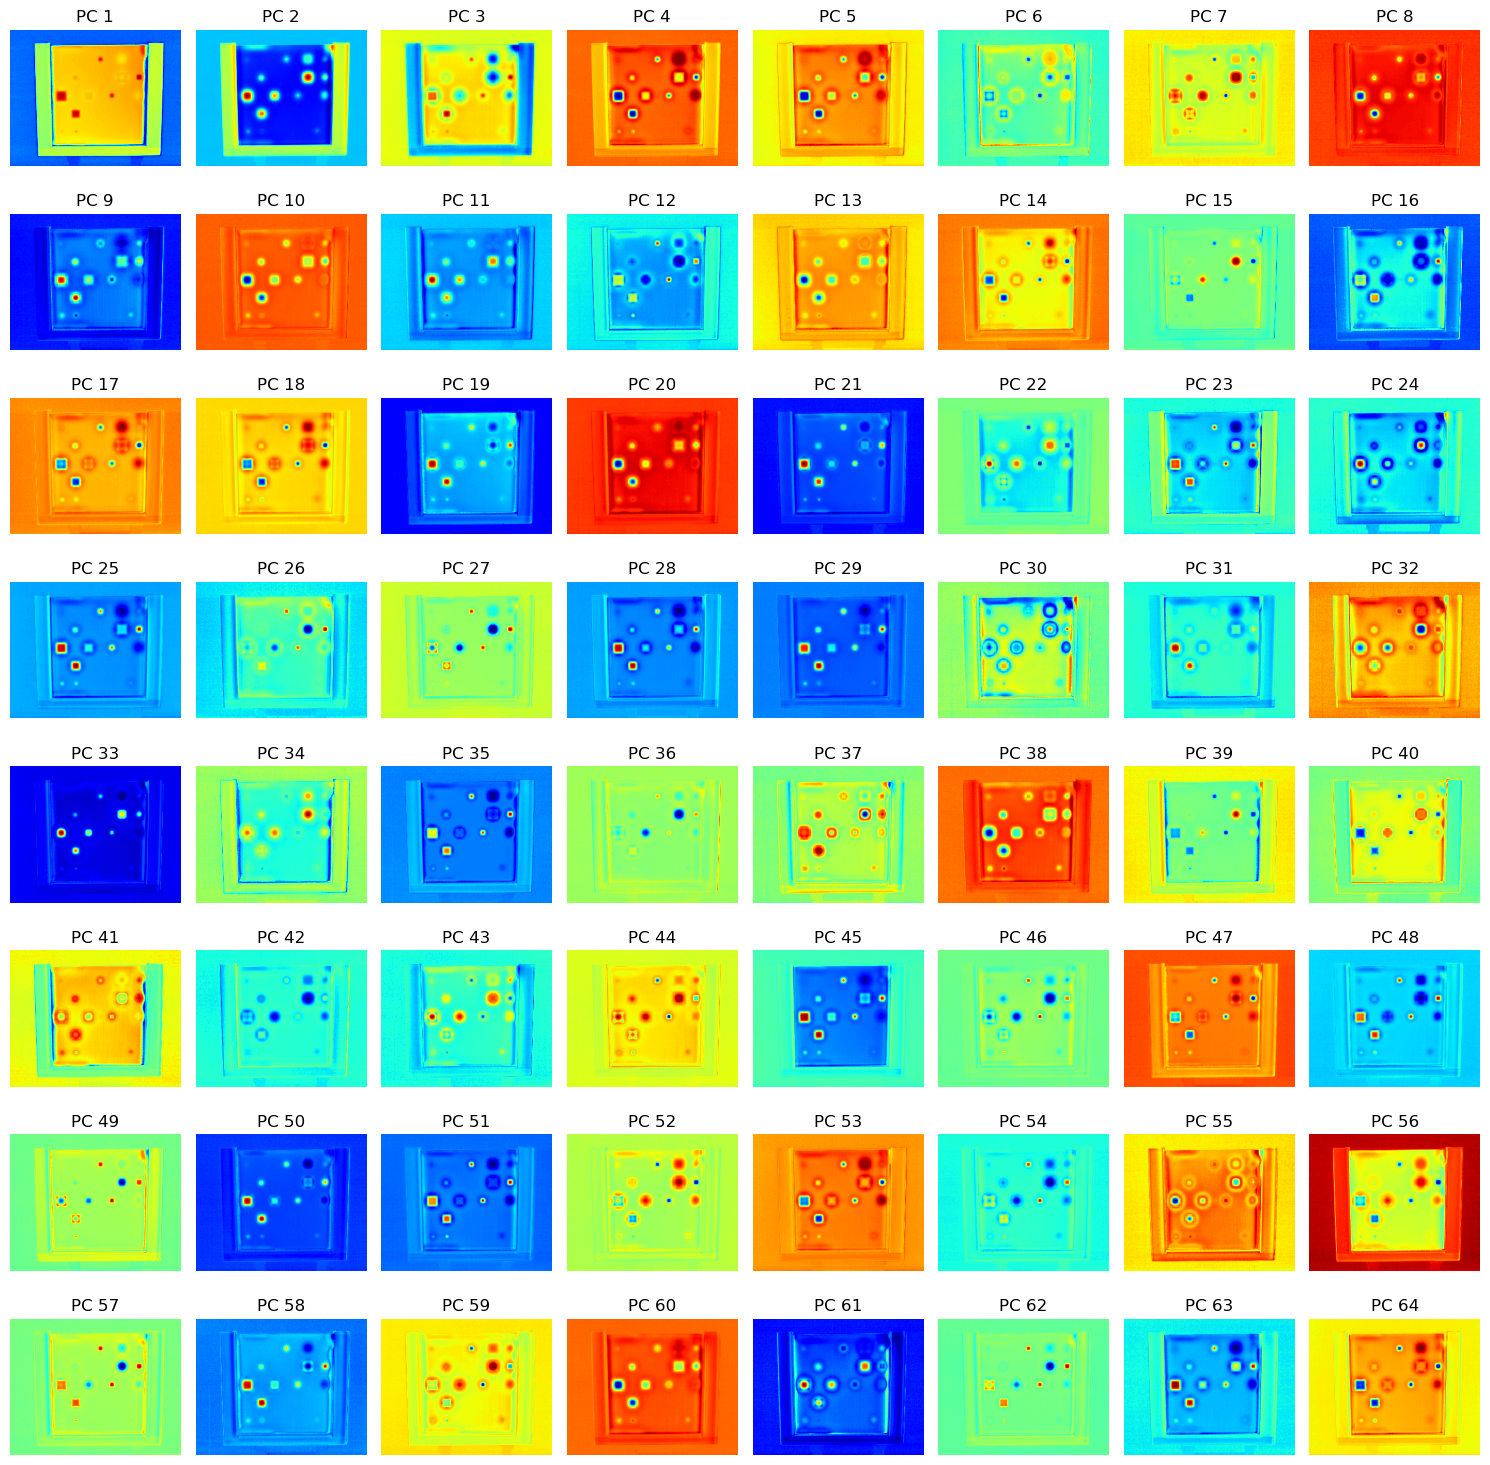

In [24]:
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_images[i], cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_images[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()